In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

In [2]:
import torch
from torch.utils.data import DataLoader

from src.data.pipeline import get_datasets
from src.models.transformer_model import StockTransformer
from src.training.trainer import Trainer
from src.utils.config import load_config

config = load_config()

train_dataset, val_dataset, test_dataset, feature_columns = get_datasets(config)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.training.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

model = StockTransformer(
    input_dim=len(feature_columns),
    d_model=config.model.d_model,
    n_heads=config.model.n_heads,
    n_layers=config.model.n_layers,
    d_ff=config.model.d_ff,
    dropout=config.model.dropout,
    activation=config.model.activation,
    prediction_horizon=config.data.prediction_horizon,
)

trainer = Trainer(
    model=model,
    config=config,
    train_loader=train_loader,
    val_loader=val_loader,
)

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)


In [3]:
history = trainer.train()

print(f"\n{'='*60}")
print(f"Обучението завърши!")
print(f"Best validation loss: {history['best_val_loss']:.6f}")
print(f"{'='*60}")

# Use project root for absolute path (same as in 05_backtest_simulation)
from src.utils import config as _cfg

# IMPORTANT: Save base model as best_model_base.pt to avoid overwriting enhanced model
# The enhanced model should stay as best_model.pt or best_model_with_news.pt
base_model_path = _cfg.PROJECT_ROOT / config.paths.models_dir / "best_model_base.pt"

# Also save to default location if it doesn't exist or if user wants to overwrite
checkpoint_name = getattr(config.paths, "checkpoint_file", "best_model.pt")
checkpoint_path = _cfg.PROJECT_ROOT / config.paths.models_dir / checkpoint_name

# Check if checkpoint_path exists and contains enhanced model
backup_existing = False
if checkpoint_path.exists():
    try:
        existing_checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        existing_state = existing_checkpoint.get('model_state_dict', {})
        has_news = any('news' in k for k in existing_state.keys())
        existing_type = existing_checkpoint.get('model_type', '')
        
        if has_news or existing_type == 'StockTransformerWithNews':
            print(f"⚠️  Warning: {checkpoint_path} contains enhanced model!")
            print(f"  Will NOT overwrite it. Base model will be saved only as best_model_base.pt")
            checkpoint_path = None  # Don't overwrite enhanced model
        else:
            print(f"ℹ️  {checkpoint_path} exists but is not enhanced model. Will overwrite.")
    except:
        print(f"⚠️  Could not check existing checkpoint. Will save to both locations.")

# Ensure directory exists
if checkpoint_path:
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
base_model_path.parent.mkdir(parents=True, exist_ok=True)

# Save base model
print(f"\nЗапазване на базов модел в: {base_model_path}")
torch.save({
    'epoch': len(history['train_losses']) - 1,
    'model_state_dict': model.state_dict(),
    'score': history['best_val_loss'],
    'model_type': 'StockTransformer',  # Explicitly mark as base model
}, base_model_path)

# Also save to default location if it's safe
if checkpoint_path:
    print(f"\nЗапазване на модела в: {checkpoint_path}")
    torch.save({
        'epoch': len(history['train_losses']) - 1,
        'model_state_dict': model.state_dict(),
        'score': history['best_val_loss'],
        'model_type': 'StockTransformer',  # Explicitly mark as base model
    }, checkpoint_path)

# VERIFICATION: Check that base model file exists and can be loaded
if base_model_path.exists():
    import time
    file_size = base_model_path.stat().st_size / (1024 * 1024)  # MB
    mtime = time.ctime(base_model_path.stat().st_mtime)
    print(f"✓ Базовият модел е запазен успешно!")
    print(f"  Файл: {base_model_path}")
    print(f"  Размер: {file_size:.2f} MB")
    print(f"  Модифициран: {mtime}")
    
    # Try loading it back to verify
    try:
        test_checkpoint = torch.load(base_model_path, map_location="cpu", weights_only=False)
        if "model_state_dict" in test_checkpoint and "score" in test_checkpoint:
            print(f"✓ Проверка: Файлът може да се зареди обратно")
            print(f"  Epoch: {test_checkpoint.get('epoch', '?') + 1}")
            print(f"  Val loss: {test_checkpoint.get('score', '?'):.6f}")
            print(f"  Model type: {test_checkpoint.get('model_type', 'unknown')}")
            print(f"  Параметри: {len(test_checkpoint['model_state_dict'])} keys")
        else:
            print(f"⚠ ВНИМАНИЕ: Файлът липсва ключови полета!")
    except Exception as e:
        print(f"✗ ГРЕШКА при зареждане на файла: {e}")
else:
    print(f"✗ ГРЕШКА: Базовият модел не беше създаден!")

Започване на обучение за 50 epochs...

Epoch 1/50... Train loss: 0.086020 Val loss: 0.032279 (18.7s)

Epoch 2/50... Train loss: 0.020783 Val loss: 0.023706 (17.4s)

Epoch 3/50... Train loss: 0.016504 Val loss: 0.024354 (17.8s)

Epoch 4/50... Train loss: 0.014751 Val loss: 0.018634 (17.6s)

Epoch 5/50... Train loss: 0.014391 Val loss: 0.017291 (18.1s)

Epoch 6/50... Train loss: 0.013804 Val loss: 0.031198 (17.5s)

Epoch 7/50... Train loss: 0.013165 Val loss: 0.026375 (17.9s)

Epoch 8/50... Train loss: 0.013147 Val loss: 0.021706 (17.4s)

Epoch 9/50... Train loss: 0.012921 Val loss: 0.022050 (17.7s)

Epoch 10/50... Train loss: 0.012026 Val loss: 0.020626 (17.3s)

Early stopping triggered after 10 epochs (patience: 5)

Обучението завърши успешно!
Best validation loss: 0.017291

Обучението завърши!
Best validation loss: 0.017291
ℹ️  C:\Users\vyoto\OneDrive\Desktop\CODE STUFF\Stock price prediction\models\checkpoints\best_model.pt exists but is not enhanced model. Will overwrite.

Запазване

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from src.evaluation.metrics import calculate_metrics

test_loader = DataLoader(
    test_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

print("Тестване на модела...")
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        predictions = model(batch_x)
        
        if predictions.dim() == 1:
            predictions = predictions.unsqueeze(1)
        if batch_y.dim() == 1:
            batch_y = batch_y.unsqueeze(1)
        
        all_predictions.append(predictions)
        all_targets.append(batch_y)

predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

metrics = calculate_metrics(predictions, targets)

print("\n" + "="*60)
print("РЕЗУЛТАТИ НА TEST SET:")
print("="*60)
for metric_name, value in metrics.items():
    if metric_name == "mape":
        print(f"{metric_name.upper()}: {value:.2f}%")
    elif metric_name == "directional_accuracy":
        print(f"{metric_name.upper()}: {value*100:.2f}%")
    else:
        print(f"{metric_name.upper()}: {value:.6f}")
print("="*60)

Тестване на модела...

РЕЗУЛТАТИ НА TEST SET:
MAE: 0.069719
RMSE: 0.086657
MAPE: 9.74%
R2: 0.092894
DIRECTIONAL_ACCURACY: 46.91%


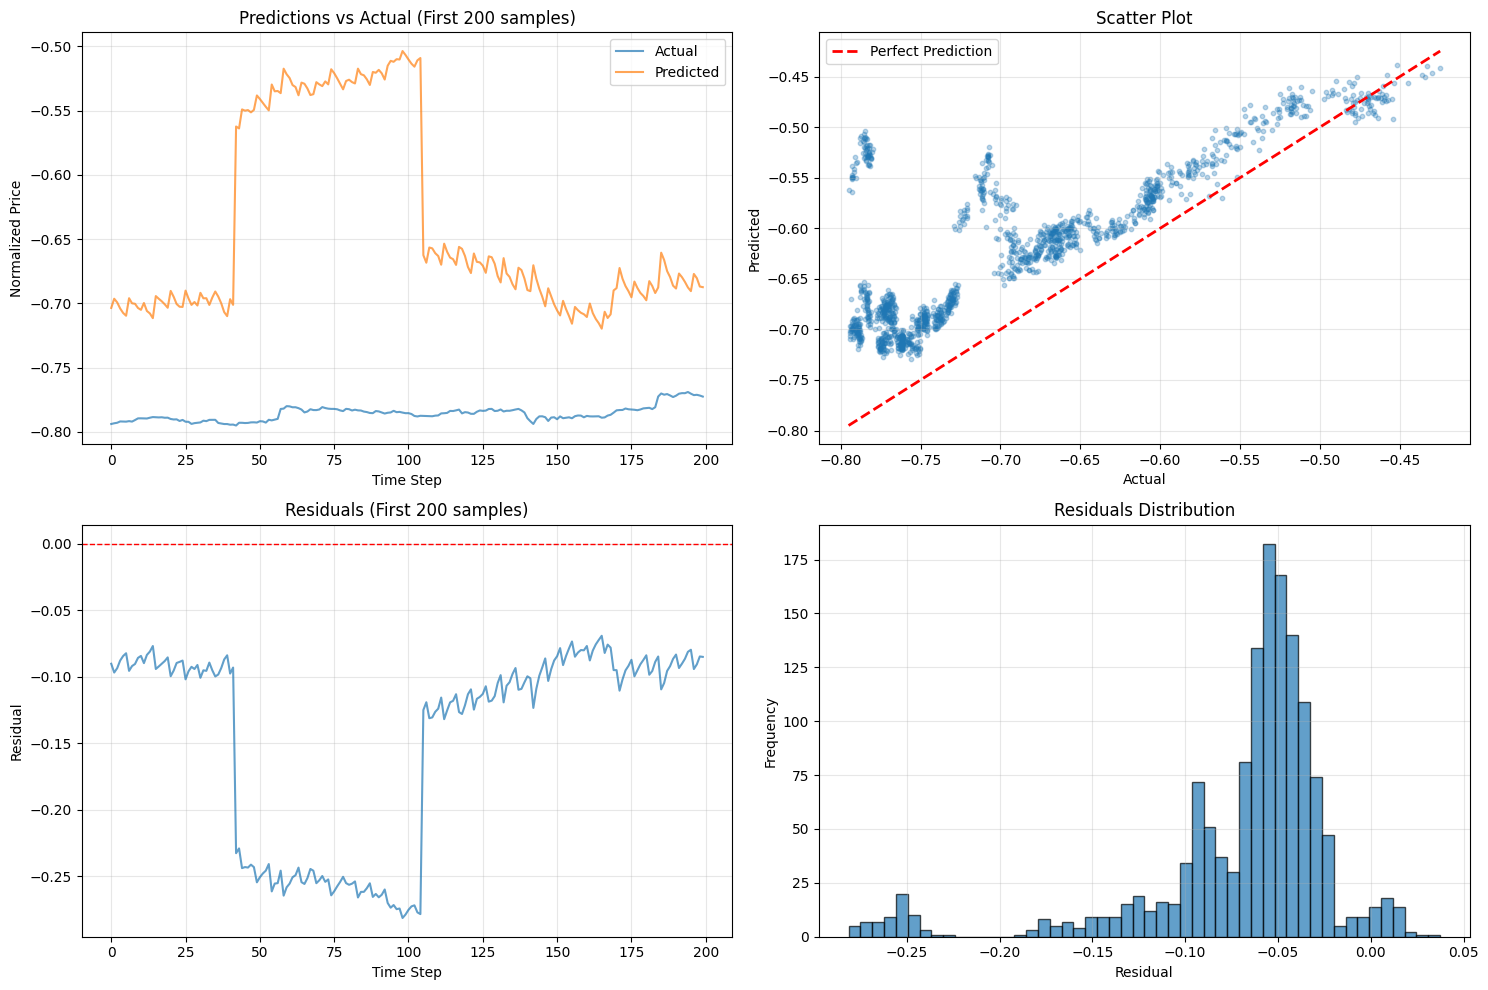


Статистики на residuals:
  Mean: -0.069014
  Std: 0.052408
  Min: -0.281407
  Max: 0.037406


In [5]:
predictions_np = predictions.numpy().flatten()
targets_np = targets.numpy().flatten()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(targets_np[:200], label="Actual", alpha=0.7, linewidth=1.5)
plt.plot(predictions_np[:200], label="Predicted", alpha=0.7, linewidth=1.5)
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.title("Predictions vs Actual (First 200 samples)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(targets_np, predictions_np, alpha=0.3, s=10)
min_val = min(np.min(targets_np), np.min(predictions_np))
max_val = max(np.max(targets_np), np.max(predictions_np))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Perfect Prediction")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Scatter Plot")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
residuals = targets_np - predictions_np
plt.plot(residuals[:200], alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Time Step")
plt.ylabel("Residual")
plt.title("Residuals (First 200 samples)")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nСтатистики на residuals:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Std: {np.std(residuals):.6f}")
print(f"  Min: {np.min(residuals):.6f}")
print(f"  Max: {np.max(residuals):.6f}")